## Imports

In [28]:
# For OS interaction and system-specific parameters
import os
import sys

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torch.optim.lr_scheduler import StepLR

# Torchvision
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets


# Albumentations for Data Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# PIL for image operations
from PIL import Image

# Matplotlib for plotting and visualizations
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# TensorBoardX - TensorBoard for PyTorch
from tensorboardX import SummaryWriter

# CodeCarbon for tracking our carbon emissions
from codecarbon import EmissionsTracker

# tqdm for showing progress bars
from tqdm.notebook import tqdm

# Import Netron for visualizing our model
import netron

# # Add scripts to directory
sys.path.append('/Users/jacob/OneDrive/Desktop/SyntheticEye/Development/src/utils')
# Import custom helper functions from the scripts directory
import helper_functions

## Gain Insights Regarding Data
This this is so we can better understand our data and helps us to decide which fixed image size to choose

In [ ]:
# Import necessary function from helper_functions.py
from helper_functions import plot_image_dimensions_bar_graph
from helper_functions import plot_class_distribution

### Plot Image Dimensions

In [ ]:
# Plotting dimensions of ai-generated images
img_dir = "/Users/jacob/OneDrive/Desktop/Aletheia4Dataset/AI/"
plot_image_dimensions_bar_graph(img_dir, heading='AI Image Dimensions')

In [ ]:
# Plotting dimensions of GAN images
img_dir = "/Users/jacob/OneDrive/Desktop/Aletheia4Dataset/GAN/"
plot_image_dimensions_bar_graph(img_dir, heading='GAN Image Dimensions')

In [ ]:
# Plotting dimensions of real images
img_dir = "/Users/jacob/OneDrive/Desktop/Aletheia4Dataset/REAL/"
plot_image_dimensions_bar_graph(img_dir, heading='Real Image Dimensions')

### Plot Class Distribution

In [ ]:
plot_class_distribution('/Users/jacob/OneDrive/Desktop/Aletheia4Dataset/')

## Prepare Data

In [ ]:
# Imports
from helper_functions import show_img

In [34]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = [img for img in os.listdir(img_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg', '.webp'))]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = np.array(Image.open(img_path).convert('RGB'))
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image

In [102]:
transform = A.Compose([
    A.SmallestMaxSize(max_size=304), 
    A.CenterCrop(256, 256), 
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.PixelDropout(dropout_prob=0.015, p=0.35),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Create the dataset
dataset = CustomImageDataset(img_dir='C:\\Users\\jacob\\OneDrive\\AugmentationTestImages', transform=transform)

In [103]:
def show_images(dataset, num_images=12):
    # Set up the figure
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
    
    for i in range(num_images):
        # Get an image from the dataset
        image = dataset[i]
        
        # If the image is a tensor, convert it to a numpy array
        if torch.is_tensor(image):
            image = image.numpy().transpose((1, 2, 0))

        # Display the image
        axes[i].imshow(image)
        axes[i].axis('off')

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

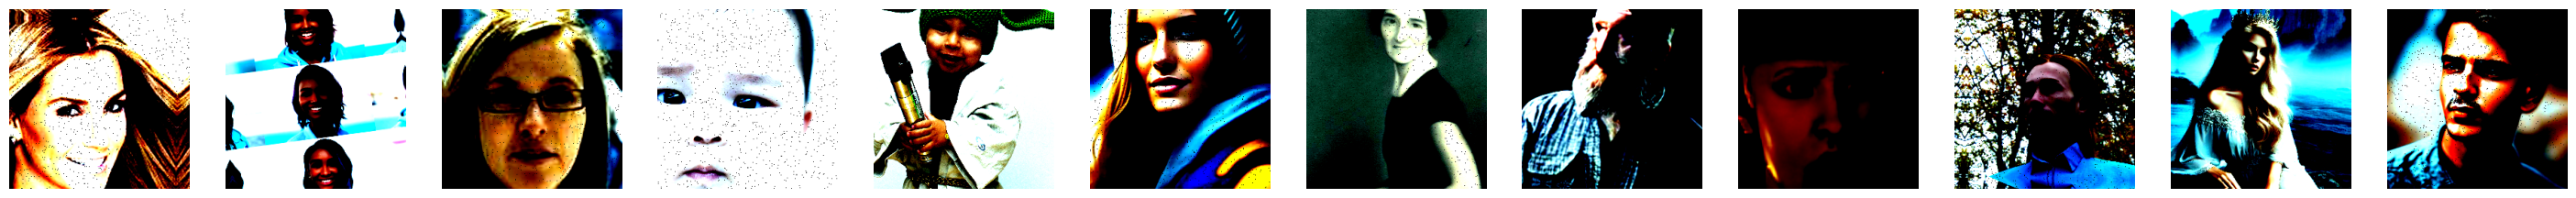

In [104]:
show_images(dataset, num_images=12)

## Create Neural Networks
We experimented with multiple model architectures. The "AdjustedResCNN" is the architecture of Aletheia 2.5 and currently in use on our website.

In [ ]:
class CNN(nn.Module):
    """
    A simpler CNN model architecture we used in the beginning.
    This model is fast, but its performance not always optimal.
    """
    def __init__(self, num_classes=2, dropout_prob=0.3):
        super(CNN, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Applying dropout with lower probability for convolutional layers
        self.dropout_conv = nn.Dropout(p=dropout_prob/3)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 64 * 64, 64)

        # Dropout layer for fully connected layers
        self.dropout_fc = nn.Dropout(p=dropout_prob)

        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Convolutional layer 1 with ReLU activation followed by MaxPooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2) 
        x = self.dropout_conv(x)

        # Convolutional layer 2 with ReLU activation followed by MaxPooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout_conv(x)

        # Flatten the output
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)

        return x

In [ ]:
class DeeperCNN(nn.Module):
    """
    A deeper CNN that's more complex than the original CNN.
    This model can detect more features but is also slower.
    """
    def __init__(self, dropout_prob=0.3):
        super(DeeperCNN, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # Convolutional layer 1
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_prob * 0.2), # A lower dropout probability for convolutional layers

            # Convolutional layer 2
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_prob * 0.2), # A lower dropout probability for convolutional layers

            # Convolutional layer 3
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_prob * 0.2), # A lower dropout probability for convolutional layers

            # Convolutional layer 4
            nn.Conv2d(128, 224, 3, 1, 1),
            nn.BatchNorm2d(224),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_prob * 0.2) # A lower dropout probability for convolutional layers
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(512, 224),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(224, 128),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(128, 1)  # Final output layer for our binary classification problem
        )

    def feature_size(self):
        """
        Compute the size of flattened features after passing through the convolutional layers.
        This is useful for determining the input size for the fully connected layers.
        """
        return self.conv_layers(torch.zeros(1, 3, 224, 224)).view(1, -1).size(1)

    def forward(self, x):
        # Pass input through convolutional layers
        x = self.conv_layers(x)
        # Flatten tensor
        x = x.view(x.size(0), -1) 
        # Pass flattened tensor through fully connected layers
        x = self.fc_layers(x)
        return x

In [ ]:
class ResBlock(nn.Module):
    """
    A residual block that consists of a convolutional block and a skip connection.
    """
    def __init__(self, in_channels, out_channels, dropout_prob=0.2):
        super(ResBlock, self).__init__()
        
        # Define main convolutional block
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob)
        )
        
        # Define skip connection and adapt channels as if needed
        self.residual = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
    
    # Pass input through main block and add skip connection
    def forward(self, x):
        out = self.block(x)
        res = self.residual(x)
        return out + res

class AdjustedResCNN(nn.Module):
    """
    This is an adjusted version of our DeeperDNN with slight adjustments and the addition of skip connections.
    This is the model architecture of our currently deployed face detection model.
    """
    def __init__(self, dropout_prob=0.3):
        super(AdjustedResCNN, self).__init__()

        # Convolutional layers with residual blocks and max-pooling. The dropout probability is reduced for the convolutional layers
        self.conv_layers = nn.Sequential(
            ResBlock(3, 24, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(24, 48, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(48, 96, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(96, 192, dropout_prob * 0.2),
            nn.MaxPool2d(2)
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.feature_size(), 448),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(448, 224),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(224, 112),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(112, 1) # Final layer with one output for our binary classification problem
        )

    def feature_size(self):
        """
        Compute size of flattend features after passing through the convolutional layers.
        This is useful for determining the input size for the fully connected layers
        """
        return self.conv_layers(torch.zeros(1, 3, 224, 224)).view(1, -1).size(1)

    def forward(self, x):
        # Pass input through convolutional layers
        x = self.conv_layers(x)
        # Flatten tensor
        x = x.view(x.size(0), -1) 
        # Pass flattened tensor through fully connected layers
        x = self.fc_layers(x)
        return x

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.3):
        super(ResBlock, self).__init__()

        # Half the out_channels for each branch
        branch_channels = out_channels // 2

        # 3x3 convolution branch
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, branch_channels, 3, 1, 1),
            nn.BatchNorm2d(branch_channels),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob)
        )

        # 5x5 convolution branch
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, branch_channels, 5, 1, 2),  # Padding is 2 to keep the same spatial dimensions
            nn.BatchNorm2d(branch_channels),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob)
        )

        # Define skip connection and adapt channels
        self.residual = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        # Apply both branches
        out3x3 = self.branch3x3(x)
        out5x5 = self.branch5x5(x)

        # Concatenate along channel dimension
        out = torch.cat([out3x3, out5x5], dim=1)

        # Apply the residual connection
        res = self.residual(x)
        return out + res

class Aletheia3Net(nn.Module):
    def __init__(self, dropout_prob=0.3):
        super(Aletheia3Net, self).__init__()

        # Convolutional layers with residual blocks and max-pooling
        self.conv_layers = nn.Sequential(
            ResBlock(3, 16, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(16, 32, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(32, 64, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(64, 128, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(128, 256, dropout_prob * 0.2)
        )

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(256, 1)
        )

    def feature_size(self):
        # Testing feature size with 304x304 input
        return self.conv_layers(torch.zeros(1, 3, 304, 304)).view(1, -1).size(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

## Set Up Device Agnostic Code

In [ ]:
# Set the device to GPU if available, else use the CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

## Hyperparamters

In [ ]:
# Define Hyperparameters
num_classes = 2
learning_rate = 0.0002
batch_size = 32
num_epochs = 36

## Data
- Load Data
- Split Data
- Apply transformations

In [ ]:
class AlbumentationsTransform:
    """
    Class to transform images using the Albumentations library
    """
    def __init__(self, transform=None):
        self.transform = transform

    # Apply Albumentations transform to the input image and convert the result to a tensor.
    def __call__(self, img):
        # Convert image to numpy array if needed
        if isinstance(img, Image.Image):
            img = np.array(img)
        
        # Convert augmented image to a tensor and normalize pixel values
        augmented = self.transform(image=img)
        img_tensor = torch.from_numpy(augmented['image'].transpose(2, 0, 1)).float() / 255.0
        return img_tensor

In [ ]:
class TorchvisionBridge:
    """
    Bridge to convert Torchvision transforms into a format that can be used with the Albumentations library.
    """
    def __init__(self, transform):
        self.transform = transform

    # Apply torchvision transformations and convert the results to a numpy array
    def __call__(self, img):
        img = self.transform(img)
        return np.array(img)

### Calculate Mean and Std of Images

In [ ]:
from helper_functions import get_image_mean_std

dataset_path = "/Users/jacob/OneDrive/Desktop/SyntheticEye/Aletheia/Dataset/"

mean, std = get_image_mean_std(dataset_path)
print(mean)
print(std)

In [ ]:
# Mean and standard deviation for normalization
mean = [0.499, 0.415, 0.372]
std = [0.245, 0.223, 0.220]

In [ ]:
# Define image transformations using both Torchvision and Albumentations libraries.

# Torchvision transforms
torchvision_transform = transforms.Compose([
    transforms.RandomAffine(degrees=3, translate=(0.03, 0.03)), # This helps making the model more robust on mobile (since users usually upload screenshots wich have a different positional format than the actual image), but a high value can weaken the accuracy on desktop (when used in the original image resultion).  
    transforms.Resize((304, 304))  # Resize all images to 304x304
])

torchvision_resize = transforms.Compose(
    transforms.Resize((304, 304)),
)

# Albumentation transforms for data augmentation
augmentation = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.06, contrast_limit=0.06, p=0.25),
    A.HorizontalFlip(p=0.4),
    A.ShiftScaleRotate(shift_limit=0.04, scale_limit=0.04, rotate_limit=7, p=0.4),
    A.PixelDropout(dropout_prob=0.014, p=0.35),
    A.Normalize(mean=mean, std=std), 
])

# Albumentation transforms for test data, where images are simply resized without additional transformation
test_augmentation = A.Compose([
    A.Resize(304, 304),
    A.Normalize(mean=mean, std=std)
])

In [ ]:
class CustomDataset(Dataset):
    """
    This Custom Dataset class is used to incorporate Torchvision and Albumentation transformations.
    """

    # Initialize CustomDataset
    def __init__(self, dataset, torchvision_transforms=None, albumentations_transform=None):
        self.dataset = dataset
        self.torchvision_transforms = torchvision_transforms
        self.albumentations_transform = AlbumentationsTransform(albumentations_transform)

    # Return number of samples in the dataset
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        # Check if dataset is a subset and get the path and target accordingly
        if isinstance(self.dataset, torch.utils.data.Subset):
            path, target = self.dataset.dataset.samples[self.dataset.indices[index]]
        else:
            path, target = self.dataset.samples[index]
        
        img = Image.open(path).convert("RGB")

        # Apply torchvision transforms if defined
        if self.torchvision_transforms:
            img = self.torchvision_transforms(img)
        
        # Apply albumentations transforms if defined
        if self.albumentations_transform:
            img = self.albumentations_transform(img)
        
        return img, target

In [ ]:
root_directory = '/Users/jacob/OneDrive/Desktop/SyntheticEye/Aletheia/Dataset/'

# Load dataset without transformations
full_dataset = datasets.ImageFolder(root=root_directory)

# Set random seed for reproducibility
torch.manual_seed(46)

# Split dataset into train, validation, and test sets
train_size = int(0.85 * len(full_dataset))  # 85%
validation_size = int(0.05 * len(full_dataset))  # 5%
test_size = len(full_dataset) - train_size - validation_size  # 10%

train_subset, validation_subset, test_subset = random_split(full_dataset, [train_size, validation_size, test_size])

# Apply transformations using the CustomDataset class
train_dataset = CustomDataset(
    train_subset, 
    torchvision_transforms=torchvision_transform, 
    albumentations_transform=augmentation
)

val_dataset = CustomDataset(
    validation_subset, 
    torchvision_transforms=torchvision_transform, 
    albumentations_transform=test_augmentation
)

test_dataset = CustomDataset(
    test_subset, 
    torchvision_transforms=torchvision_transform, 
    albumentations_transform=test_augmentation
)


# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Training

### Prepare Training 

In [ ]:
# Set a random seed for reproducibility
torch.manual_seed(3)

# Initialize model and transfer it to the GPU if available
model = Aletheia3Net().to(device)

In [ ]:
# Use BCEWithLogitsLoss for our binary classification problem
loss_function = nn.BCEWithLogitsLoss()
# Define NAdam (a veriant of the Adam optimizer) as our optimizer
optimizer = optim.NAdam(model.parameters(), lr=learning_rate)
# Define learning rate scheduler to adjust our learning rate
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

In [ ]:
# Initialize TensorBoard summary writer
writer = SummaryWriter(f'runs/Aletheia3_0')
step = 0

In [ ]:
# Import necessary function for checking accuracy of our model from helper_functions.py
from helper_functions import check_accuracy

### Train Model

In [ ]:
# Initialize EmissionsTracker to tracker to monitor carbon emissions using the CodeCarbon library
carbon_tracker = EmissionsTracker(project_name="Aletheia3_0", log_level="critical")
carbon_tracker.start()

# Initialize tracking of correct predictions and total predictions
correct = 0
samples = 0

torch.manual_seed(3)

model = model.to(device)

# Set up log interval for recording metrics
metrics_interval = 250

# Start training
for epoch in range(num_epochs):

    # Reset accuracy counters at beginning of each epoch
    correct = 0
    samples = 0
    
    # Switch model to training mode
    model.train()

    # Train model on each batch of the train_loader and display progress in current epoch using tqdm
    for batch_index, (data, targets) in tqdm(enumerate(train_loader), total=len(train_loader), desc="Progress in epoch"):

        # Move data and targets to the device
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward pass
        scores = model(data)
        scores = scores.squeeze(1)
        loss = loss_function(scores.view(-1), targets.float()) # Compute loss based on model's predictions

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        # Convert to binary decisions
        preds = (torch.sigmoid(scores) > 0.5).float()

        # Update accuracy counters
        correct += (preds == targets).sum().item()
        samples += preds.size(0)
        # Calculate accuracy as percentage
        accuracy = 100 * correct / samples


        if batch_index % metrics_interval == 0:
            # Log metrics to TensorBoard
            writer.add_scalar('Training Loss', loss, epoch * len(train_loader) + batch_index)
            writer.add_scalar('Training Accuracy', accuracy, epoch * len(train_loader) + batch_index)
            # Print metrics
            print("Epoch: ", epoch)
            print(f'Got {correct} / {samples} correct with an accuracy {accuracy:.2f}% on training data.')


    # Print accumulated accuracy for epoch
    print("Epoch: ", epoch)
    print(f'Got {correct} / {samples} correct with an accuracy {accuracy:.2f}% on training data.')
    scheduler.step()

    # Evaluate the model on validation set after each epoch
    print("Checking accuracy on Test Data")
    correct_test, samples_test = check_accuracy(val_loader, model)
    test_accuracy = 100 * float(correct_test) / float(samples_test)

    # Log test accuracy to TensorBoard
    writer.add_scalar('Test Accuracy', test_accuracy, epoch) 

    # Save state of model after each epcoh
    torch.save(model.state_dict(), f'/Users/jacob/OneDrive/Desktop/SyntheticEye/SyntheticEyeLocal/StateDicts/Aletheia/3_0/al3_0_epoch_{epoch}_correct{correct}.pth')

# Stop EmmisionsTracker
emissions = carbon_tracker.stop()

# Display total carbon emissions
print(f"Emissions: {emissions:.5f} kgCO2eq")

## Test state_dict of Trained Model

In [ ]:
model = Aletheia3Net().to(device)

# Create a dummy input and perform a forward pass to create the fc1 layer
sample_input = torch.randn(1, 3, 304, 304).to(device)
model(sample_input)

# Specify path to the trained model weights
model_path = "C:\\Users\\jacob\\OneDrive\\Desktop\\SyntheticEye\\SyntheticEyeLocal\\StateDicts\\Aletheia\\3_0\\al3_0_epoch_33_correct240773.pth"

# Load trained weights into the model
model.load_state_dict(torch.load(model_path))

model = model.to(device)

In [ ]:
# Check accuracy of trained model on the test data
check_accuracy(test_loader, model, device)

In [ ]:
# Visualize Model using Netron
netron.start("C:\\Users\\jacob\\OneDrive\\Desktop\\SyntheticEye\\SyntheticEyeLocal\\StateDicts\\Aletheia\\3_0\\al3_0_epoch_35_correct240789.pth")

### Test on Specific Source

In [ ]:
# Load the new dataset
new_root_directory = "/Users/jacob/OneDrive/StyleGAN images"

new_full_dataset = datasets.ImageFolder(root=new_root_directory)

# Apply data augmentation and images transformations
new_test_dataset = CustomDataset(
    new_full_dataset, 
    albumentations_transform=test_augmentation
)

# Create a DataLoader for the new dataset
new_test_loader = DataLoader(new_test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate accuracy on new dataset
check_accuracy(new_test_loader, model, device)

### Test on Custom Images

In [ ]:
# Load model that will be used to predict individual images
model_path = "C:\\Users\\jacob\\OneDrive\\Desktop\\SyntheticEye\\SyntheticEyeLocal\\StateDicts\\Aletheia\\3_0\\al3_0_epoch_33_correct240773.pth"
model.load_state_dict(torch.load(model_path))
model.to(device)

In [ ]:
def single_image_transforms():
    """
    Combine torchvision and albumentations transforms for an individual image
    """

    tv_transform = tv_transform = TorchvisionBridge(torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224))]))
    alb_transform = AlbumentationsTransform(test_augmentation)
    
    # Apply both transformations to the given image
    def combined_transforms(img):
        img = tv_transform(img)
        return alb_transform(img)
    
    return combined_transforms

In [ ]:
# Import function for getting predictions on a single image
from helper_functions import predict_single_image
# Import function for displaying predictions on multiple images
from helper_functions import display_folder_images

In [ ]:
img_path = "/Users/jacob/OneDrive/Desktop/clearlyai.webp"

# Use predict_single_imge function to predict a single image
predicted_label = predict_single_image(
    img_path, 
    model,
    # Use Albumentations to transform the image as needed
    AlbumentationsTransform(test_augmentation)
)

# Print prediction for the given image
print(f"Predicted probability for image: {predicted_label}")

In [ ]:
# Load combined transformations and display images with their predicted probabilities
combined_transforms = single_image_transforms()
display_folder_images("/Users/jacob/OneDrive/Desktop/SyntheticEyeLocal/EvalData/Aletheia/MultipleEval/", model, combined_transforms)